In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
DATA_DIR = '../data/internal'

In [3]:
class Config:
    """
    Configuration class for the recommendation system model.

    Attributes:
    - device (str): Device to be used for training ('cpu' or 'cuda').
    - epochs (int): Number of training epochs.
    - seed (int): Random seed for reproducibility.
    - batch_size (int): Batch size for training.
    - embedding_dim (int): Dimensionality of the user and item embeddings.
    - hidden_size (int): Size of the hidden layers in the fully connected network.
    - dropout_rate (float): Dropout rate to prevent overfitting.
    - lr (float): Learning rate for the optimizer.
    """
    device = 'cpu'
    epochs = 20
    seed = 0
    batch_size = 128
    embedding_dim = 32
    hidden_size = 16
    dropout_rate=0.5
    lr = 1e-3


config = Config()

In [4]:
def set_seed(seed_value=0):
    """
    Set random seeds for reproducibility in Python and PyTorch.

    Args:
    - seed_value (int): Seed value to use for random number generation.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


set_seed(config.seed)

In [5]:
train_data = pd.read_csv(os.path.join(DATA_DIR, 'data_train.csv'))
val_data = pd.read_csv(os.path.join(DATA_DIR, 'data_val.csv'))
user_data = pd.read_csv(os.path.join(DATA_DIR, 'user.csv'), index_col=0)
item_data = pd.read_csv(os.path.join(DATA_DIR, 'item.csv'), index_col=0)

In [6]:
original_user_ids = user_data.original_user_id - user_data.original_user_id.min()
original_item_ids = item_data.original_item_id - item_data.original_item_id.min()

In [7]:
user_data = user_data.drop(columns=['original_user_id'])
item_data = item_data.drop(columns=['original_item_id'])

In [8]:
n_user_features = user_data.shape[1]
n_item_features = item_data.shape[1]
n_user_features, n_item_features

(22, 19)

In [9]:
class MovieDataset(Dataset):
    """
    PyTorch Dataset class for handling movie recommendation data.

    Args:
    - ratings (pd.DataFrame): DataFrame containing user-item ratings.
    - users (pd.DataFrame): DataFrame containing user information.
    - items (pd.DataFrame): DataFrame containing item information.
    """
    def __init__(self, ratings, users, items):
        self.users = users
        self.items = items
        self.ratings = ratings

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, ids):
        """
        Gets a single sample from the dataset.

        Args:
        - ids: Index or indices to retrieve the sample(s).

        Returns:
        - dict: A dictionary containing the following tensors:
            - "ratings": Tensor containing user-item ratings.
            - "user_ids": Tensor containing user IDs.
            - "item_ids": Tensor containing item IDs.
            - "users_info": Tensor containing additional user features.
            - "items_info": Tensor containing additional item features.
        """
        ratings = self.ratings.iloc[ids]

        user_ids = ratings.user_id.astype('int')
        item_ids = ratings.item_id.astype('int')

        users = self.users.iloc[user_ids]
        items = self.items.iloc[item_ids]

        return {
            "ratings": torch.tensor(ratings.rating, dtype=torch.long),
            "user_ids": torch.tensor(user_ids, dtype=torch.long),
            "item_ids": torch.tensor(item_ids, dtype=torch.long),
            "users_info": torch.tensor(users.to_numpy(), dtype=torch.float),
            "items_info": torch.tensor(items.to_numpy(), dtype=torch.float),
        }

In [10]:
train_dataset = MovieDataset(train_data, user_data, item_data)
val_dataset = MovieDataset(val_data, user_data, item_data)

In [11]:
train_dataloader = DataLoader(
    train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=config.batch_size, shuffle=False)

In [12]:
for data in train_dataloader:
    print(data['ratings'].shape)
    print(data['user_ids'].shape)
    print(data['item_ids'].shape)
    print(data['users_info'].shape)
    print(data['items_info'].shape)
    break

torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([128, 22])
torch.Size([128, 19])


In [13]:
class RecSysModel(nn.Module):
    """
    A PyTorch-based neural network model for collaborative filtering in recommendation systems.

    Args:
    - n_users (int): Number of users in the recommendation system.
    - n_items (int): Number of items in the recommendation system.
    - embedding_dim (int): Dimensionality of the user and item embeddings.
    - hidden_size (int): Size of the hidden layers in the fully connected network.
    - dropout_rate (float): Dropout rate to prevent overfitting.
    - n_item_features (int): Number of features for each item in the recommendation system.
    - n_user_features (int): Number of features for each user in the recommendation system.
    """
    def __init__(self, n_users, n_items, embedding_dim, hidden_size, dropout_rate):
        super().__init__()

        self.user_embed = nn.Embedding(n_users, embedding_dim=embedding_dim)
        self.item_embed = nn.Embedding(n_items, embedding_dim=embedding_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim * 2 + n_item_features + n_user_features, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.fc3 = nn.Linear(hidden_size // 2, 1)

        # Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, user_ids, item_ids, users_info, items_info):
        """
        Forward pass of the model.

        Args:
        - user_ids (torch.Tensor): Tensor containing user IDs.
        - item_ids (torch.Tensor): Tensor containing item IDs.
        - users_info (torch.Tensor): Tensor containing additional user features.
        - items_info (torch.Tensor): Tensor containing additional item features.

        Returns:
        - torch.Tensor: Predicted ratings for the given user-item pairs.
        """
        user_embeds = self.user_embed(user_ids)
        item_embeds = self.item_embed(item_ids)

        x = torch.cat([user_embeds, item_embeds, users_info, items_info], dim=1)

        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        
        return x

In [14]:
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
    - train_losses (list): List of training loss values for each epoch.
    - val_losses (list): List of validation loss values for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [15]:
def test_model(model: nn.Module, criterion, test_dataloader: DataLoader, device='cuda'):
    """
    Evaluates the performance of a recommendation system model on a test dataset.

    Args:
    - model (nn.Module): The recommendation system model.
    - criterion: The loss function for evaluation.
    - test_dataloader (DataLoader): DataLoader for the test dataset.
    - device (str): Device to be used for evaluation ('cpu' or 'cuda').

    Returns:
    - float: The average test loss value.
    """
    model.eval()
    model.to(device)

    # Test loss value
    test_loss = 0.0

    with torch.no_grad():
        for data in test_dataloader:
            
            user_ids = data['user_ids'].to(device)
            item_ids = data['item_ids'].to(device)
            users_info = data['users_info'].to(device)
            items_info = data['items_info'].to(device)
            ratings = data['ratings'].to(device)
            
            ratings = ratings.view(-1, 1).to(torch.float)            
            
            # Forward pass
            outputs = model(user_ids=user_ids, item_ids=item_ids, users_info=users_info, items_info=items_info)
            test_loss += criterion(outputs, ratings)

    # Computation of test loss
    test_loss /= len(test_dataloader)

    return test_loss.item()

In [16]:
def train_model(model: nn.Module, epochs: int, criterion, train_dataloader, validation_dataloader, load_ckpt: bool = False, load_ckpt_path: str or None = None, save_ckpt_path: str = 'best.pt', device: torch.device = 'cuda'):
    """
    Trains a recommendation system model using the provided data.

    Args:
    - model (nn.Module): The recommendation system model.
    - epochs (int): Number of training epochs.
    - criterion: The loss function used for training.
    - train_dataloader: DataLoader for the training dataset.
    - validation_dataloader: DataLoader for the validation dataset.
    - load_ckpt (bool): Whether to load a checkpoint from a file.
    - load_ckpt_path (str or None): Path to the checkpoint file to load. If None, it uses 'best.pt'.
    - save_ckpt_path (str): Path to save the best model checkpoint.
    - device (torch.device): Device to be used for training ('cuda' or 'cpu').

    Returns:
    - None
    """

    if load_ckpt_path is None:
        load_ckpt_path = save_ckpt_path

    model.train()
    model.to(device)

    # best score for checkpointing
    best = 1000000000.0
    train_losses = []
    val_losses = []

    first_epoch = 1

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)


    if (not load_ckpt):
        print('Training model from scratch!')
    else:
        isCkptExists = os.path.isfile(load_ckpt_path)        
        if (not isCkptExists):
            print('Checkpoint file does not exist. Training model from scratch!')
        else:
            checkpoint = torch.load(load_ckpt_path)
            best = checkpoint['best_score']
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            train_losses = checkpoint['train_losses']
            first_epoch = checkpoint['epoch'] + 1

    # Train the model
    for epoch in range(first_epoch, epochs + first_epoch):
        model.train()

        train_loss = 0.0

        bar = tqdm(train_dataloader)
        iterations = 0

        for data in bar:

            user_ids = data['user_ids'].to(device)
            item_ids = data['item_ids'].to(device)
            users_info = data['users_info'].to(device)
            items_info = data['items_info'].to(device)
            ratings = data['ratings'].to(device)
            
            ratings = ratings.view(-1, 1).to(torch.float)            
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(user_ids=user_ids, item_ids=item_ids, users_info=users_info, items_info=items_info)
            loss = criterion(outputs, ratings)

            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            iterations += 1
            bar.set_postfix(
                ({"loss": f"{train_loss/(iterations*train_dataloader.batch_size)}"}))

        # Computing loss
        train_loss /= len(train_dataloader.dataset)

        # Printing information in the end of train loop
        val_loss = test_model(model, criterion, validation_dataloader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        plot_losses(train_losses=train_losses, val_losses=val_losses)

        if val_loss < best:
            best = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_score': best,
            }, save_ckpt_path)

        print(f"Epoch {epoch}: \ntrain:\t\t(loss: {train_loss:.4f}) \nvalidation:\t(loss: {val_loss:.4f})\n")

In [17]:
model = RecSysModel(n_items=len(item_data), n_users=len(
    user_data), embedding_dim=config.embedding_dim, hidden_size=config.hidden_size, dropout_rate=config.dropout_rate).to(config.device)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()

Training model from scratch!


100%|██████████| 522/522 [00:52<00:00, 10.01it/s, loss=0.0415882016442916]  


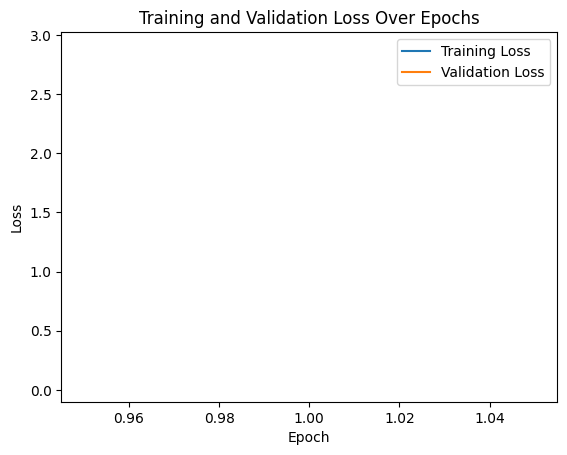

Epoch 1: 
train:		(loss: 0.0416) 
validation:	(loss: 2.8815)



100%|██████████| 522/522 [00:40<00:00, 12.86it/s, loss=0.024733831538636793]


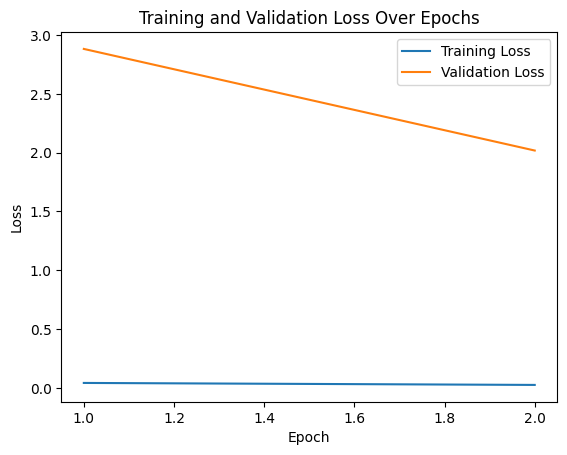

Epoch 2: 
train:		(loss: 0.0248) 
validation:	(loss: 2.0176)



100%|██████████| 522/522 [00:43<00:00, 11.88it/s, loss=0.019621862715888068]


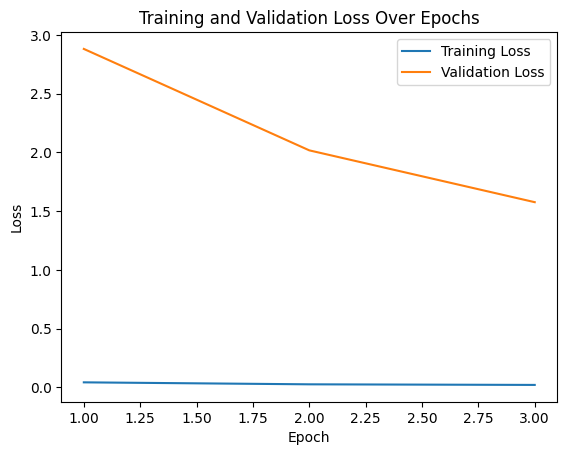

Epoch 3: 
train:		(loss: 0.0196) 
validation:	(loss: 1.5762)



100%|██████████| 522/522 [00:50<00:00, 10.28it/s, loss=0.01642602800223905] 


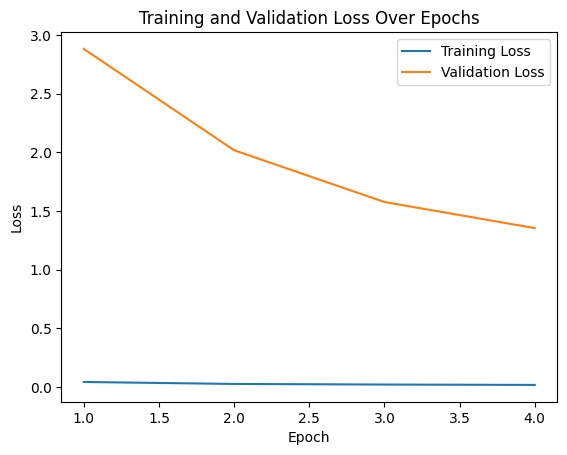

Epoch 4: 
train:		(loss: 0.0164) 
validation:	(loss: 1.3537)



100%|██████████| 522/522 [00:46<00:00, 11.31it/s, loss=0.014316985089246226]


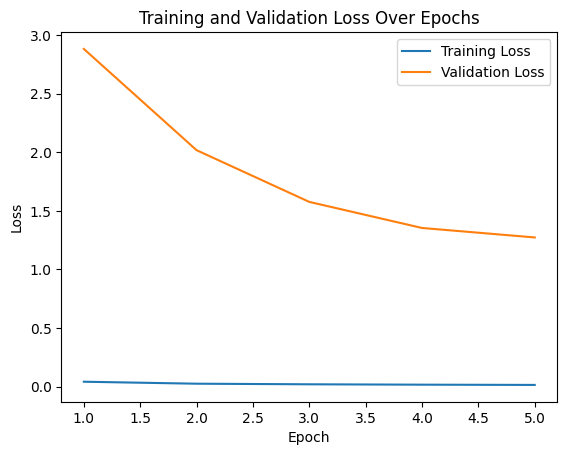

Epoch 5: 
train:		(loss: 0.0143) 
validation:	(loss: 1.2728)



100%|██████████| 522/522 [00:43<00:00, 12.07it/s, loss=0.012824988988196027]


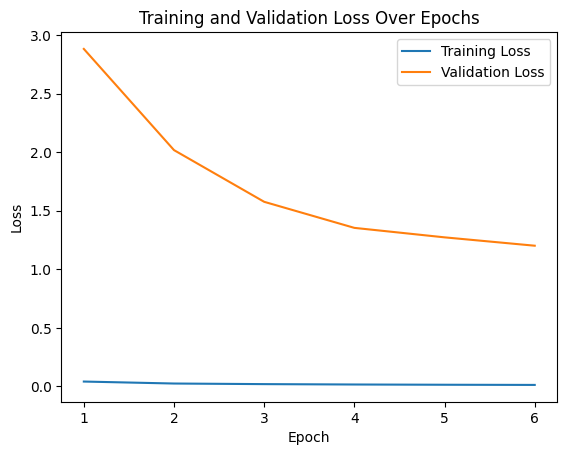

Epoch 6: 
train:		(loss: 0.0128) 
validation:	(loss: 1.2014)



100%|██████████| 522/522 [00:42<00:00, 12.14it/s, loss=0.011644230274148142]


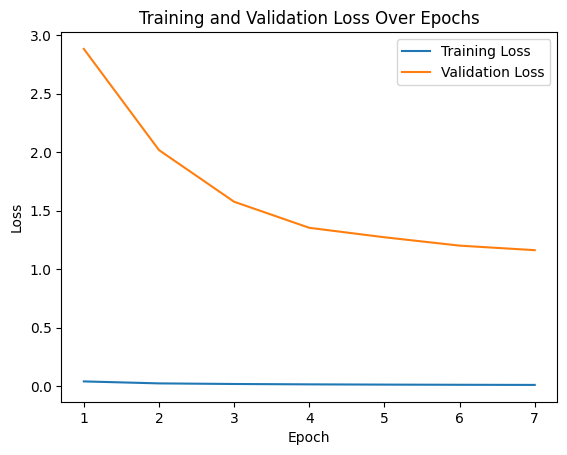

Epoch 7: 
train:		(loss: 0.0117) 
validation:	(loss: 1.1626)



100%|██████████| 522/522 [00:42<00:00, 12.18it/s, loss=0.010753087416626657]


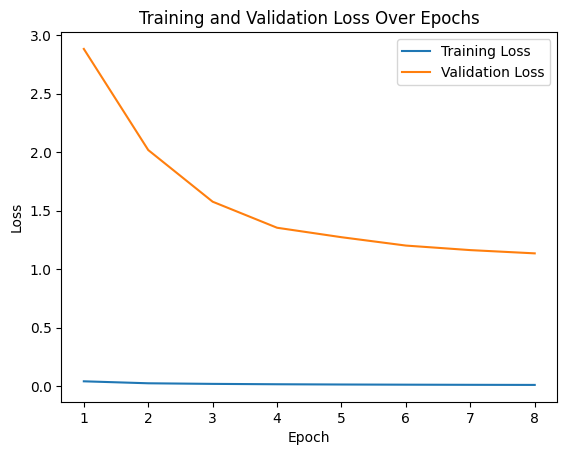

Epoch 8: 
train:		(loss: 0.0108) 
validation:	(loss: 1.1348)



100%|██████████| 522/522 [00:44<00:00, 11.74it/s, loss=0.010024611054923228]


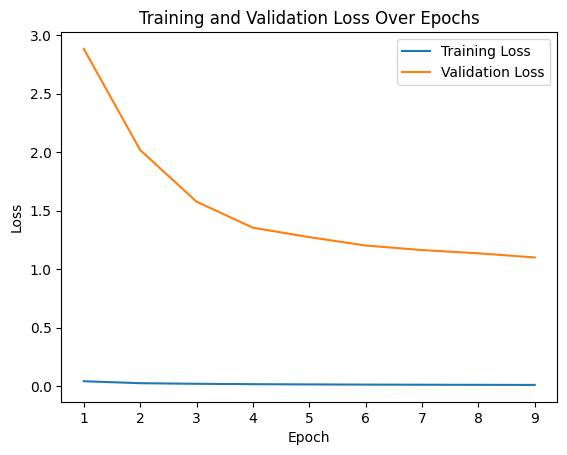

Epoch 9: 
train:		(loss: 0.0100) 
validation:	(loss: 1.0995)



100%|██████████| 522/522 [00:43<00:00, 11.98it/s, loss=0.009303540665784786]


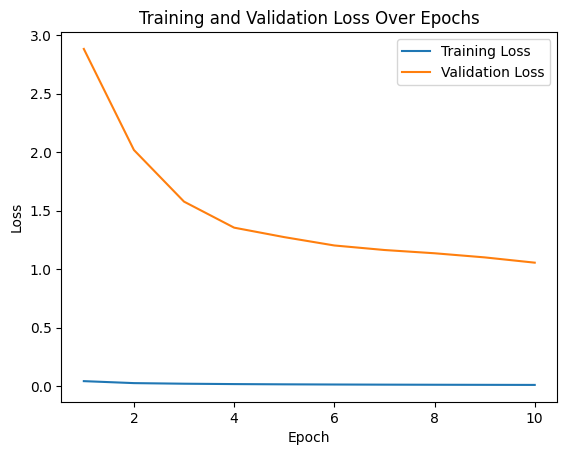

Epoch 10: 
train:		(loss: 0.0093) 
validation:	(loss: 1.0544)



100%|██████████| 522/522 [00:42<00:00, 12.30it/s, loss=0.008841996266724278]


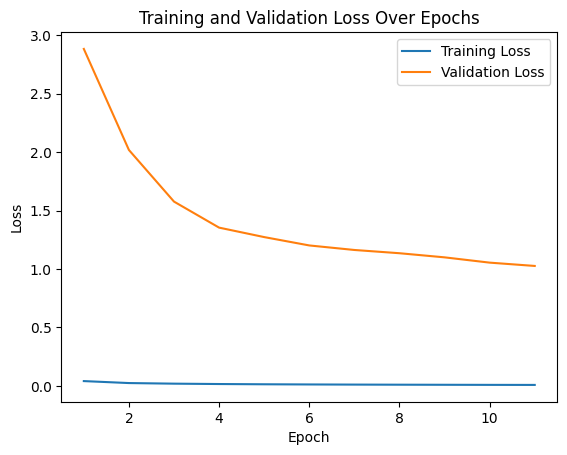

Epoch 11: 
train:		(loss: 0.0089) 
validation:	(loss: 1.0261)



100%|██████████| 522/522 [00:45<00:00, 11.58it/s, loss=0.008461682581774519]


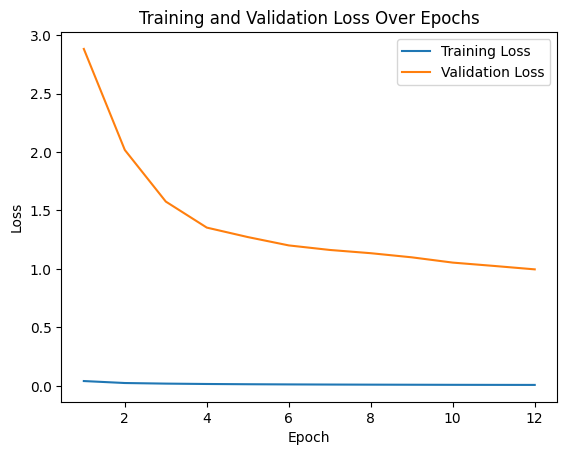

Epoch 12: 
train:		(loss: 0.0085) 
validation:	(loss: 0.9966)



100%|██████████| 522/522 [00:50<00:00, 10.24it/s, loss=0.008231726973727916]


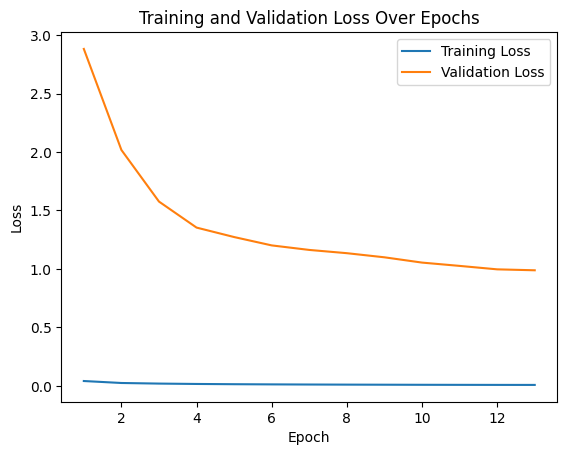

Epoch 13: 
train:		(loss: 0.0082) 
validation:	(loss: 0.9886)



100%|██████████| 522/522 [00:42<00:00, 12.27it/s, loss=0.008046472756463278]


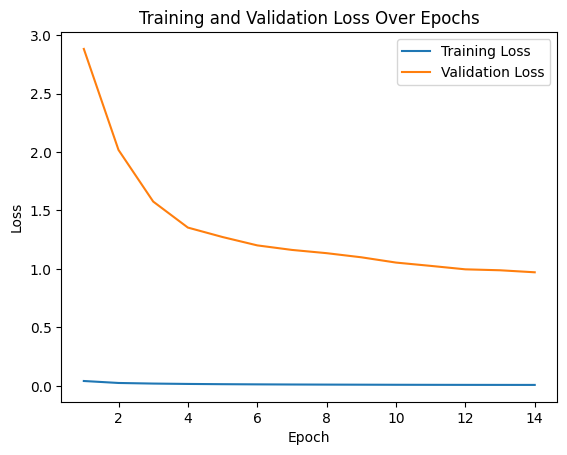

Epoch 14: 
train:		(loss: 0.0081) 
validation:	(loss: 0.9713)



100%|██████████| 522/522 [00:42<00:00, 12.27it/s, loss=0.00790338652026465] 


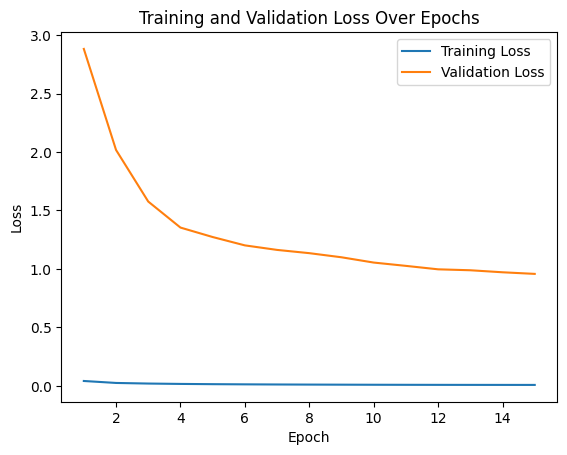

Epoch 15: 
train:		(loss: 0.0079) 
validation:	(loss: 0.9575)



100%|██████████| 522/522 [00:38<00:00, 13.53it/s, loss=0.007798158911581354] 


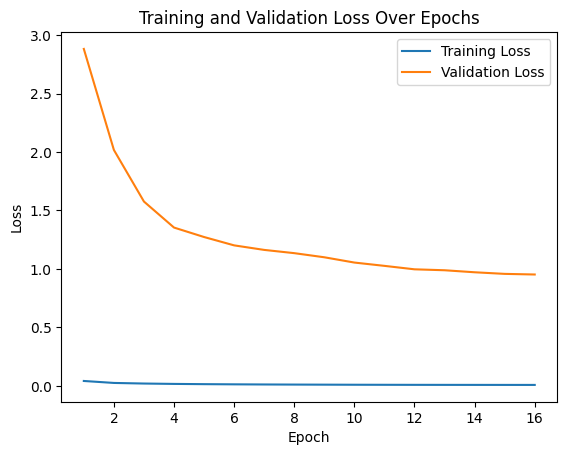

Epoch 16: 
train:		(loss: 0.0078) 
validation:	(loss: 0.9522)



100%|██████████| 522/522 [00:40<00:00, 12.92it/s, loss=0.00773505058756876]  


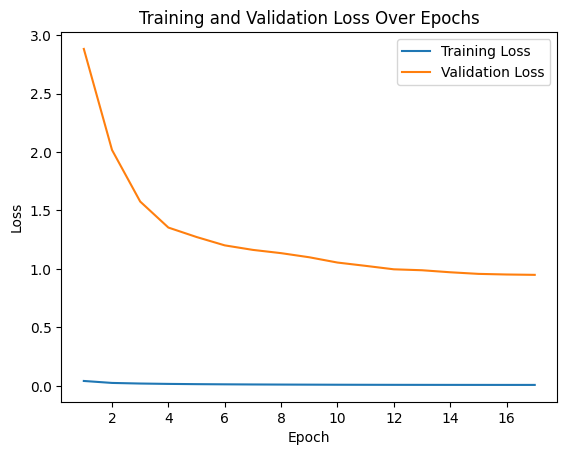

Epoch 17: 
train:		(loss: 0.0077) 
validation:	(loss: 0.9491)



100%|██████████| 522/522 [00:46<00:00, 11.13it/s, loss=0.007696019481132485] 


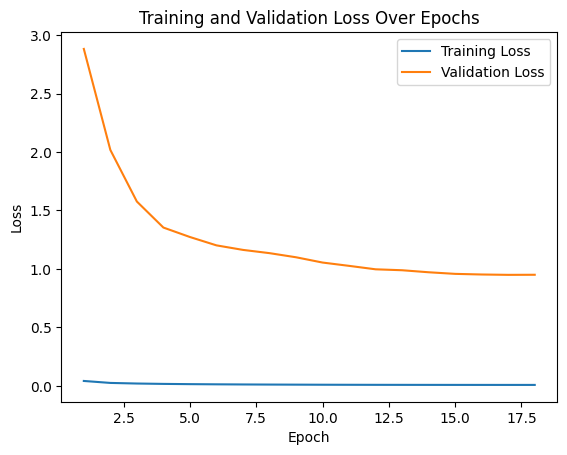

Epoch 18: 
train:		(loss: 0.0077) 
validation:	(loss: 0.9499)



100%|██████████| 522/522 [00:44<00:00, 11.75it/s, loss=0.007652359014605368] 


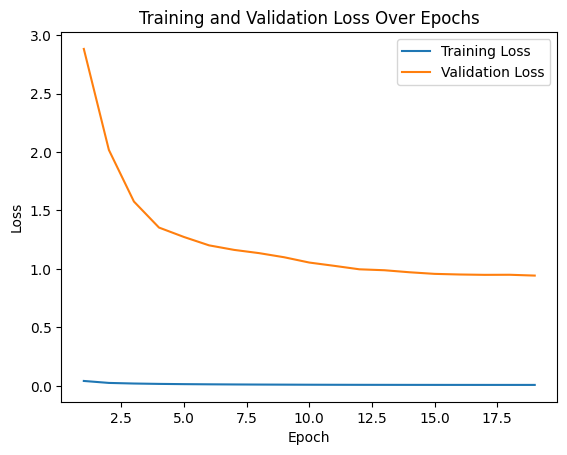

Epoch 19: 
train:		(loss: 0.0077) 
validation:	(loss: 0.9428)



100%|██████████| 522/522 [00:46<00:00, 11.13it/s, loss=0.007675759307861728] 


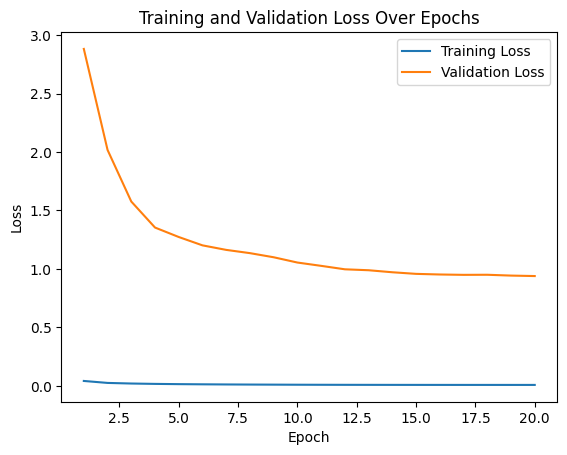

Epoch 20: 
train:		(loss: 0.0077) 
validation:	(loss: 0.9388)



In [18]:
train_model(model=model, epochs=config.epochs, criterion=loss_fn, train_dataloader=train_dataloader, validation_dataloader=val_dataloader, save_ckpt_path="../models/embedding-based/best.pt")

In [19]:
checkpoint = torch.load('../models/embedding-based/best.pt')

In [20]:
model.eval()
model.to(config.device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
def dup_rows(a, indx, num_dups=1):
    """
    Duplicate a specific row in a numpy array along a specified axis.

    Args:
    - a (numpy.ndarray): The input array.
    - indx (int): The index of the row to be duplicated.
    - num_dups (int, optional): The number of times to duplicate the row. Default is 1.

    Returns:
    - numpy.ndarray: An array with the specified row duplicated.
    """
    return np.insert(a,[indx+1]*num_dups,a[indx],axis=0)

In [22]:
def get_top_k_movies(model, user_id, k=10):
    """
    Generates the top k movie recommendations for a specific user using a recommendation model.

    Args:
    - model: The recommendation system model.
    - user_id (int): The ID of the user for whom recommendations are to be generated.
    - k (int): The number of top recommendations to retrieve.

    Returns:
    - list: A list of tuples, where each tuple contains the recommended item ID and predicted rating.
    """
    model.eval()

    watched_movies = val_data[val_data.user_id == user_id].item_id

    unwatched_movies = item_data[~item_data.index.isin(watched_movies)]

    unwatched_movie_ids = unwatched_movies.index.to_list()

    users_info_one_row = user_data.iloc[user_id]
    
    users_info = dup_rows(users_info_one_row.to_numpy()[np.newaxis, ...],
                          0, len(unwatched_movie_ids)-1)

    user_ids = [user_id] * len(unwatched_movie_ids)

    items_info = np.zeros((len(unwatched_movie_ids), n_item_features))
    for i, movie_id in enumerate(unwatched_movie_ids):
        items_info[i] = item_data.iloc[movie_id].to_numpy()

    user_ids = torch.tensor(user_ids).to(dtype=torch.long)
    item_ids = torch.tensor(unwatched_movie_ids).to(dtype=torch.long)
    users_info = torch.tensor(users_info).to(dtype=torch.float)
    items_info = torch.tensor(items_info).to(dtype=torch.float)

    with torch.no_grad():
        output = model(user_ids=user_ids, item_ids=item_ids,
                       users_info=users_info, items_info=items_info).squeeze()

    unwatched_movies_with_rating = list(
        zip(unwatched_movie_ids, output.numpy()))

    top_k = sorted(unwatched_movies_with_rating,
                   key=lambda x: x[1], reverse=True)[:k]

    return top_k

In [23]:
SOURCE_DATA_DIR = '../data/raw/ml-100k'

In [24]:
df_item = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.item'), sep='|', encoding = "ISO-8859-1", header=None)
genre_columns = ["unknown", "action", "adventure", "animation", "children", "comedy", "crime", "documentary", "drama", "fantasy", "film_noir", "horror", "musical", "mystery", "romance", "sci_fi", "thriller", "war", "western"]
df_item.columns = ["movie_id", "movie_title", "release_date", "video_release_date", "imdb_url"] + genre_columns
df_item = df_item.drop(columns=['video_release_date'])
df_item = df_item.set_index('movie_id')

In [25]:
df_user = pd.read_csv(os.path.join(SOURCE_DATA_DIR, 'u.user'), sep='|', header=None)
df_user.columns = ["user_id", "age", "gender", "occupation", "zip_code"]
df_user = df_user.set_index('user_id')

In [26]:
class ItemInfo:
    """
    Class representing information about a movie.

    Args:
    - movie_id (int): The unique identifier for the movie.
    - movie_title (str): The title of the movie.
    - release_date (str): The release date of the movie.
    - genre_series (pd.Series): A pandas Series representing movie genres.

    Attributes:
    - movie_id (int): The unique identifier for the movie.
    - movie_title (str): The title of the movie.
    - release_date (str): The release date of the movie.
    - genres (list): A list of genres associated with the movie.
    """
    def __init__(self, movie_id, movie_title, release_date, genre_series):
        self.movie_id = movie_id
        self.movie_title = movie_title
        self.release_date = release_date
        self.genres = [genre for genre, value in genre_series.items() if value == 1]
    def __str__(self) -> str:
        return f'Movie (id {self.movie_id}):\ttitle: {self.movie_title},\tgenres: {self.genres}'

In [41]:
class UserInfo:
    """
    Class representing information about a user.

    Args:
    - user_id (int): The unique identifier for the user.
    - age (int): The age of the user.
    - gender (str): The gender of the user.
    - occupation (str): The occupation of the user.
    - zip_code (str): The ZIP code of the user.

    Attributes:
    - user_id (int): The unique identifier for the user.
    - age (int): The age of the user.
    - gender (str): The gender of the user.
    - occupation (str): The occupation of the user.
    - zip_code (str): The ZIP code of the user.
    """
    def __init__(self, user_id, age, gender, occupation, zip_code):
        self.user_id = user_id
        self.age = age
        self.gender = gender
        self.occupation = occupation
        self.zip_code = zip_code
    def __repr__(self) -> str:
        return f'User (id {self.user_id}):\tage: {self.age},\tgender: {self.gender},\toccupation: {self.occupation}'

In [28]:
def get_item_info(item_id):
    """
    Retrieves information about a movie based on its item ID.

    Args:
    - item_id (int): The item ID of the movie.

    Returns:
    - ItemInfo: An object containing information about the movie.
    """
    original_id = original_item_ids.iloc[item_id]
    item_series = df_item.iloc[original_id]
    item_data = ItemInfo(movie_id=original_id, movie_title=item_series.movie_title, release_date=item_series.release_date, genre_series=item_series.loc[genre_columns])
    return item_data

In [29]:
def get_user_info(user_id):
    """
    Retrieves information about a user based on their user ID.

    Args:
    - user_id (int): The user ID of the user.

    Returns:
    - UserInfo: An object containing information about the user.
    """
    original_id = original_user_ids.iloc[user_id]
    user_series = df_user.iloc[original_id]
    user_data = UserInfo(user_id=original_id, age=user_series.age, gender=user_series.gender, occupation=user_series.occupation, zip_code=user_series.zip_code)
    return user_data

In [30]:
def get_user_recommendations(user_id, k=5):
    """
    Display top movie recommendations for a user.

    Args:
    - user_id (int): The user ID for whom recommendations are generated.
    - k (int): The number of recommendations to display. Default is 5.
    """
    print(get_user_info(user_id=user_id))
    print(f"Top {k} recommendations:")
    item_ratings = get_top_k_movies(model=model, user_id=user_id, k=k)
    for i, (item_id, rating) in enumerate(item_ratings):
        print(f'{i+1}. Rating: {rating:0.3f}', end='. ')
        print(get_item_info(item_id=item_id))
        print()

In [31]:
def get_user_watched_movies(user_id, k=5):
    """
    Display top watched movies for a user.

    Args:
    - user_id (int): The user ID for whom watched movies are displayed.
    - k (int): The number of watched movies to display. Default is 5.
    """
    print(get_user_info(user_id=user_id))
    print(f"Top {k} recommendations:")
    watched_movies = val_data[val_data.user_id == user_id].item_id
    watched_movie_ids = watched_movies.to_list()

    watched_movies_with_rating = []

    for i, movie_id in enumerate(watched_movie_ids):
        rating = val_data[(val_data.item_id == movie_id) & (val_data.user_id == user_id)].rating.values[0]
        watched_movies_with_rating.append((movie_id, rating))

    item_ratings = sorted(watched_movies_with_rating,key=lambda x: x[1], reverse=True)[:k]

    for i, (item_id, rating) in enumerate(item_ratings):
        print(f'{i+1}. Rating: {rating:0.3f}', end='. ')
        print(get_item_info(item_id=item_id))
        print()
    


In [32]:
get_user_watched_movies(user_id=667, k=10)

User (id 877):	age: 50,	gender: F,	occupation: educator
Top 10 recommendations:
1. Rating: 5.000. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

2. Rating: 5.000. Movie (id 473):	title: Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963),	genres: ['sci_fi', 'war']

3. Rating: 5.000. Movie (id 415):	title: Old Yeller (1957),	genres: ['children', 'drama']

4. Rating: 5.000. Movie (id 511):	title: Wings of Desire (1987),	genres: ['comedy', 'drama', 'romance']

5. Rating: 4.000. Movie (id 196):	title: Graduate, The (1967),	genres: ['drama', 'romance']

6. Rating: 3.000. Movie (id 173):	title: Raiders of the Lost Ark (1981),	genres: ['action', 'adventure']

7. Rating: 2.000. Movie (id 235):	title: Citizen Ruth (1996),	genres: ['comedy', 'drama']

8. Rating: 2.000. Movie (id 139):	title: Homeward Bound: The Incredible Journey (1993),	genres: ['adventure', 'children']

9. Rating: 1.000. Movie (id 534):	title: Addicted to Love (1997),	genres:

In [33]:
get_user_recommendations(user_id=667, k=10)

User (id 877):	age: 50,	gender: F,	occupation: educator
Top 10 recommendations:
1. Rating: 3.975. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

2. Rating: 3.973. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

3. Rating: 3.924. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

4. Rating: 3.916. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

5. Rating: 3.915. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

6. Rating: 3.893. Movie (id 602):	title: Rear Window (1954),	genres: ['mystery', 'thriller']

7. Rating: 3.888. Movie (id 407):	title: Close Shave, A (1995),	genres: ['animation', 'comedy', 'thriller']

8. Rating: 3.884. Movie (id 271):	title: Good Will Hunting (1997),	genres: ['drama']

9. Rating: 3.878. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

10. Rating: 3.875. Movie (id 478):	title: Vertigo

In [34]:
get_user_watched_movies(user_id=335, k=10)

User (id 444):	age: 21,	gender: M,	occupation: writer
Top 10 recommendations:
1. Rating: 5.000. Movie (id 474):	title: Trainspotting (1996),	genres: ['drama']

2. Rating: 4.000. Movie (id 208):	title: This Is Spinal Tap (1984),	genres: ['comedy', 'drama', 'musical']

3. Rating: 3.000. Movie (id 885):	title: Life Less Ordinary, A (1997),	genres: ['romance', 'thriller']

4. Rating: 2.000. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

5. Rating: 2.000. Movie (id 297):	title: Face/Off (1997),	genres: ['action', 'sci_fi', 'thriller']

6. Rating: 2.000. Movie (id 870):	title: Vegas Vacation (1997),	genres: ['comedy']

7. Rating: 2.000. Movie (id 978):	title: Trigger Effect, The (1996),	genres: ['drama', 'thriller']

8. Rating: 2.000. Movie (id 236):	title: Jerry Maguire (1996),	genres: ['drama', 'romance']

9. Rating: 1.000. Movie (id 761):	title: Beautiful Girls (1996),	genres: ['drama']

10. Rating: 1.000. Movie (id 751):	title: Replacement Killers, The (1998),

In [35]:
get_user_recommendations(user_id=335, k=10)

User (id 444):	age: 21,	gender: M,	occupation: writer
Top 10 recommendations:
1. Rating: 3.649. Movie (id 605):	title: All About Eve (1950),	genres: ['drama']

2. Rating: 3.584. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

3. Rating: 3.571. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

4. Rating: 3.547. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

5. Rating: 3.498. Movie (id 602):	title: Rear Window (1954),	genres: ['mystery', 'thriller']

6. Rating: 3.485. Movie (id 212):	title: Room with a View, A (1986),	genres: ['drama', 'romance']

7. Rating: 3.427. Movie (id 478):	title: Vertigo (1958),	genres: ['mystery', 'thriller']

8. Rating: 3.405. Movie (id 1049):	title: Ghost and Mrs. Muir, The (1947),	genres: ['drama', 'romance']

9. Rating: 3.402. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

10. Rating: 3.376. Movie (id 407):	title: Close Shave, A (1995

In [40]:
get_user_watched_movies(user_id=559, k=10)

User (id 726):	age: 25,	gender: M,	occupation: student
Top 10 recommendations:
1. Rating: 5.000. Movie (id 171):	title: Empire Strikes Back, The (1980),	genres: ['action', 'adventure', 'drama', 'romance', 'sci_fi', 'war']

2. Rating: 5.000. Movie (id 247):	title: Grosse Pointe Blank (1997),	genres: ['comedy', 'crime']

3. Rating: 4.000. Movie (id 86):	title: Searching for Bobby Fischer (1993),	genres: ['drama']

4. Rating: 4.000. Movie (id 290):	title: Absolute Power (1997),	genres: ['mystery', 'thriller']

5. Rating: 4.000. Movie (id 201):	title: Groundhog Day (1993),	genres: ['comedy', 'romance']

6. Rating: 4.000. Movie (id 540):	title: Mortal Kombat (1995),	genres: ['action', 'adventure']

7. Rating: 4.000. Movie (id 207):	title: Young Frankenstein (1974),	genres: ['comedy', 'horror']

8. Rating: 4.000. Movie (id 525):	title: Ben-Hur (1959),	genres: ['action', 'adventure', 'drama']

9. Rating: 4.000. Movie (id 992):	title: Hercules (1997),	genres: ['adventure', 'animation', 'childr

In [37]:
get_user_recommendations(user_id=559, k=10)

User (id 726):	age: 25,	gender: M,	occupation: student
Top 10 recommendations:
1. Rating: 4.084. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

2. Rating: 4.078. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

3. Rating: 4.054. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

4. Rating: 3.990. Movie (id 11):	title: Usual Suspects, The (1995),	genres: ['crime', 'thriller']

5. Rating: 3.989. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

6. Rating: 3.979. Movie (id 271):	title: Good Will Hunting (1997),	genres: ['drama']

7. Rating: 3.974. Movie (id 49):	title: Star Wars (1977),	genres: ['action', 'adventure', 'romance', 'sci_fi', 'war']

8. Rating: 3.965. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

9. Rating: 3.962. Movie (id 407):	title: Close Shave, A (1995),	genres: ['animation', 'comedy', 'thriller']

10. Rating: 3.947. Movie (id 113):

In [38]:
get_user_watched_movies(user_id=700, k=10)

User (id 917):	age: 40,	gender: M,	occupation: scientist
Top 10 recommendations:
1. Rating: 5.000. Movie (id 427):	title: Harold and Maude (1971),	genres: ['comedy']

2. Rating: 4.000. Movie (id 581):	title: Piano, The (1993),	genres: ['drama', 'romance']

3. Rating: 4.000. Movie (id 165):	title: Manon of the Spring (Manon des sources) (1986),	genres: ['drama']

4. Rating: 4.000. Movie (id 920):	title: Farewell My Concubine (1993),	genres: ['drama', 'romance']

5. Rating: 3.000. Movie (id 0):	title: Toy Story (1995),	genres: ['animation', 'children', 'comedy']

6. Rating: 3.000. Movie (id 484):	title: My Fair Lady (1964),	genres: ['musical', 'romance']

7. Rating: 3.000. Movie (id 69):	title: Four Weddings and a Funeral (1994),	genres: ['comedy', 'romance']

8. Rating: 2.000. Movie (id 288):	title: Evita (1996),	genres: ['drama', 'musical']

9. Rating: 2.000. Movie (id 150):	title: Willy Wonka and the Chocolate Factory (1971),	genres: ['adventure', 'children', 'comedy']

10. Rating: 2.

In [39]:
get_user_recommendations(user_id=700, k=10)

User (id 917):	age: 40,	gender: M,	occupation: scientist
Top 10 recommendations:
1. Rating: 4.208. Movie (id 63):	title: Shawshank Redemption, The (1994),	genres: ['drama']

2. Rating: 4.171. Movie (id 317):	title: Schindler's List (1993),	genres: ['drama', 'war']

3. Rating: 4.112. Movie (id 512):	title: Third Man, The (1949),	genres: ['mystery', 'thriller']

4. Rating: 4.098. Movie (id 640):	title: Paths of Glory (1957),	genres: ['drama', 'war']

5. Rating: 4.087. Movie (id 168):	title: Wrong Trousers, The (1993),	genres: ['animation', 'comedy']

6. Rating: 4.079. Movie (id 407):	title: Close Shave, A (1995),	genres: ['animation', 'comedy', 'thriller']

7. Rating: 4.054. Movie (id 177):	title: 12 Angry Men (1957),	genres: ['drama']

8. Rating: 4.045. Movie (id 602):	title: Rear Window (1954),	genres: ['mystery', 'thriller']

9. Rating: 4.033. Movie (id 113):	title: Wallace & Gromit: The Best of Aardman Animation (1996),	genres: ['animation']

10. Rating: 4.022. Movie (id 473):	title: